**Reconocimiento de Neumonía con imágenes de radiografias**

***Grupo 04***

***Andrés Viñé Sánchez, Beatriz Aedo Díaz, Candela Esquinas Sánchez, José Antonio Ruiz Heredia***

## 1. Importación de librerías y cargar datos

In [121]:
# TensorFlow 
import tensorflow as tf
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Otros
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import time
import cv2
import seaborn as sns
from Data_Paths import *


Parámetros de preprocesado

In [122]:
blur = 1
contraste = 2.5
grid = 8
umbral = 120
resize = 220

### 1.1. Image Data Generators

In [123]:
# Función para redimensionar una imagen
def resize_image(image):
    resized_image = cv2.resize(image, (resize, resize))
    return resized_image

# Función umbral
def threshold_image(image):
  _, threshold_image = cv2.threshold(image, umbral, 255, cv2.THRESH_BINARY)  
  return threshold_image


# Función PreProcesado
def preprocess_image(img):
    resized_img = resize_image(img)
    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    smooth_img = cv2.medianBlur(gray_img, blur)
    clahe = cv2.createCLAHE(clipLimit = contraste, tileGridSize=(grid,grid))
    contrast_img = clahe.apply(smooth_img)
    threshold_img = threshold_image(contrast_img)
    
    return preprocess_input(threshold_img)

# Función DataAugmentation
# def custom_augmentation(img):
#     preprocessed_img = preprocess_image(img)

#     # Apply masking (Circular mask)
#     mask = np.zeros_like(preprocessed_img)
#     center = (preprocessed_img.shape[0] // 2, preprocessed_img.shape[1] // 2)
#     radius = min(preprocessed_img.shape[0], preprocessed_img.shape[1]) // 3
#     cv2.circle(mask, center, radius, (255, 255, 255), -1)
#     masked_image = cv2.bitwise_and(preprocessed_img, mask)

#     # Add noise
#     noisy_image = cv2.addWeighted(masked_image, 1, 0.2 * np.random.randn(*masked_image.shape), 0, 0)

#     return preprocess_input(noisy_image)


In [124]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input

)


In [125]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATASET,
    target_size = (220, 220),
    batch_size = 16,
    class_mode = 'binary'
)
validation_generator = val_datagen.flow_from_directory(
        TEST_DATASET,
        target_size = (220, 220),
        batch_size = 8,
        class_mode = 'binary'
)
test_generator = test_datagen.flow_from_directory(
    VAL_DATASET,
    shuffle = False,
    target_size = (220, 220),
    batch_size = 32,
    class_mode = 'binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## 2. Entrenamos el modelo

### 2.1. ResNet50V2

In [126]:
input_shape = (220, 220, 3)

# Cargamos el modelo pre-entrenado
base_model = ResNet50V2(weights = 'imagenet',
                        input_shape = input_shape,
                        include_top = False)

for layer in base_model.layers:
    layer.trainable = False
    
# Añadimos nuevas capas
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

In [127]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ ?                      │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [128]:
CHECKPOINT_PATH = os.path.join(MODEL_DATASET, 'pneumonia_classification_model_checkpoint.weights.h5')

# Create checkpoint callback.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH,
                                      save_weights_only = True,
                                      monitor = "val_accuracy",
                                      save_best_only = True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs.
# If val loss decreases for 3 epochs, stop training.
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                            mode = "min",
                                            patience = 3, 
                                            restore_best_weights = True)

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = 100,
                    epochs = 10,
                     callbacks=[checkpoint_callback, callback])

Epoch 1/10


c:\src\Personal\SI\Chest_X_Ray_Pneumonia_Detection\sistemas_inteligentes\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.7631 - loss: 0.4945 - val_accuracy: 0.7660 - val_loss: 0.4627
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8570 - loss: 0.3203 - val_accuracy: 0.7115 - val_loss: 0.5744
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8931 - loss: 0.2589 - val_accuracy: 0.7340 - val_loss: 0.5339
Epoch 4/10
 26/100 ━━━━━━━━━━━━━━━━━━━━ 54s 734ms/step - accuracy: 0.8835 - loss: 0.2715

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2288.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 466ms/step - accuracy: 0.8897 - loss: 0.2557 - val_accuracy: 0.6763 - val_loss: 0.7754


Save the model

In [129]:
MODEL_DATAPATH = os.path.join(MODEL_DATASET, 'pneumonia_classification_model_checkpoint.keras')

# Save the entire model
save_model(model, 'pneumonia_classification_model_checkpoint.keras', overwrite=True)
loaded_model = load_model('pneumonia_classification_model_checkpoint.keras')

### 3. Model metrics

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

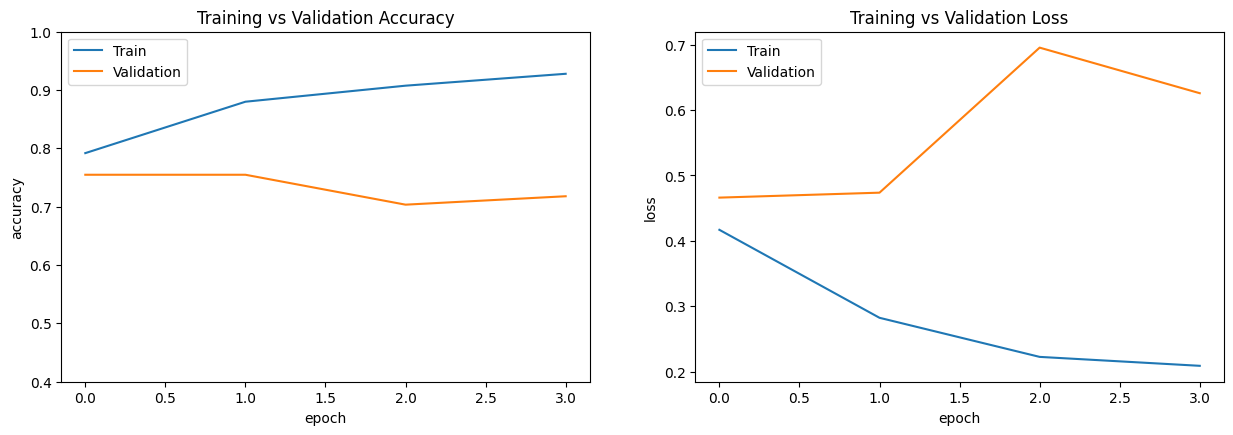

In [ ]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

## 4. Predictions

In [ ]:
loaded_model = load_model(MODEL_DATAPATH)

# Load the model weights
weights = np.load(CHECKPOINT_PATH)
loaded_model.set_weights(weights)

ValueError: Layer 'dense_4_2' expected 1 input(s). Received 2 instead.

In [ ]:
# Make predictions for the test data.
pred = loaded_model.predict(test_generator)

NameError: name 'modelo_cargado' is not defined

In [ ]:
pred

array([[0.82881856],
       [0.66847456],
       [0.7587309 ],
       [0.49887013],
       [0.8181151 ],
       [0.71339923],
       [0.22876811],
       [0.36334005],
       [0.91121423],
       [0.9485158 ],
       [0.9213381 ],
       [0.7456968 ],
       [0.886002  ],
       [0.9696433 ],
       [0.94709736],
       [0.67383814]], dtype=float32)

In [ ]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [ ]:
y_pred

[0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
# Take the true information of the test data.
y_true = test_generator.classes

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
cm = confusion_matrix(y_true, y_pred)

Text(50.72222222222221, 0.5, 'Truth')

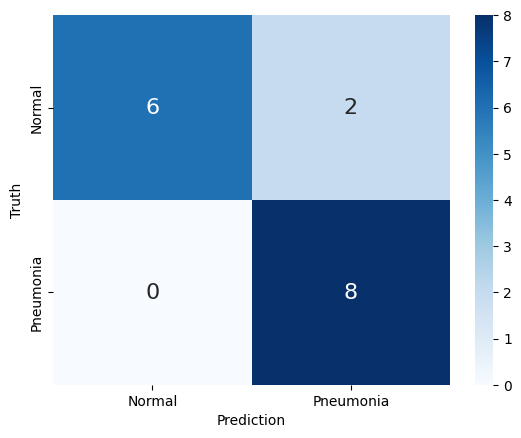

In [ ]:
# Define the class names.
class_names = ['Normal', 'Pneumonia']

# Create the heatmap with class names as tick labels.
ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

# Set the axis labels.
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



In [ ]:
# Classify the test data cases into true negative, true positive, false positive,
# and false negative cases.
confusion = []

for i, j in zip(y_true, y_pred):
  if i == 0 and j == 0:
    confusion.append('TN')
  elif i == 1 and j == 1:
    confusion.append('TP')
  elif i == 0 and j == 1:
    confusion.append('FP')
  else:
    confusion.append('FN')

In [ ]:
confusion_table = pd.DataFrame(data = confusion, columns = ["Results"])
confusion_table

,Results
0,TN
1,TN
2,TN
3,FP
4,TN
5,FP
6,TN
7,TN
8,TP
9,TP


In [ ]:
# Create a table with prediction, truth, and results.
confusion_table = pd.DataFrame({'Predicton':y_pred,
                                'Truth': y_true,
                                'Results': confusion})
confusion_table

,Predicton,Truth,Results
0,0,0,TN
1,0,0,TN
2,0,0,TN
3,1,0,FP
4,0,0,TN
5,1,0,FP
6,0,0,TN
7,0,0,TN
8,1,1,TP
9,1,1,TP


In [ ]:
FPs = confusion_table[confusion_table['Results'] == 'FP']
FPs

,Predicton,Truth,Results
3,1,0,FP
5,1,0,FP


In [ ]:
FNs = confusion_table[confusion_table['Results'] == 'FN']
FNs

,Predicton,Truth,Results


In [ ]:
normal_test_images = glob.glob(VAL_DATASET + "/NORMAL/*.jpeg")
pneumonia_test_images = glob.glob(VAL_DATASET + "/PNEUMONIA/*.jpeg")

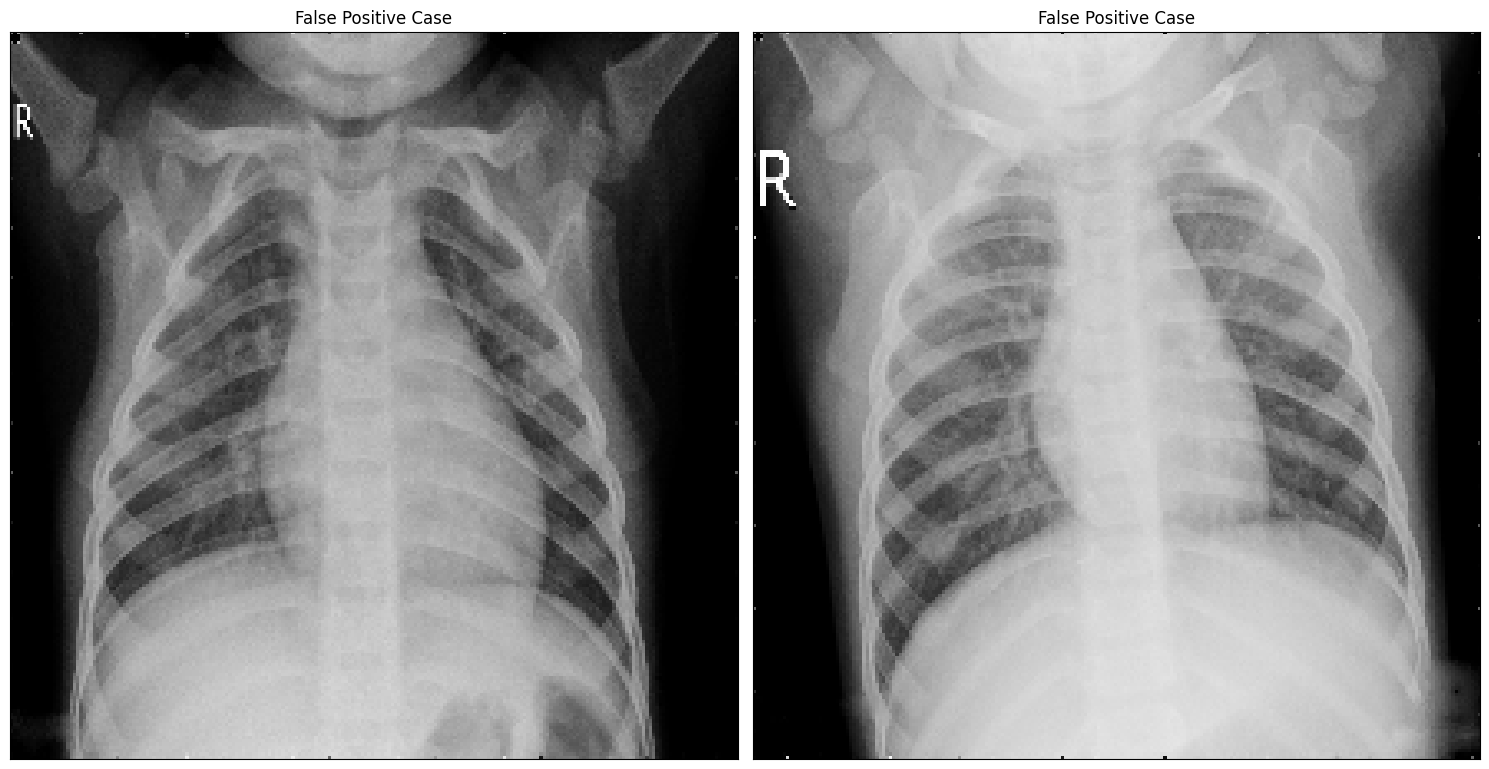

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
# Visualize the false positive case(s) in the test data.
for i, ax in zip(FPs.index, axes.flat):
    img = cv2.imread(normal_test_images[i])
    img = cv2.resize(img, (220, 220))
    ax.imshow(img)
    ax.set_title("False Positive Case")
fig.tight_layout()    

plt.show()

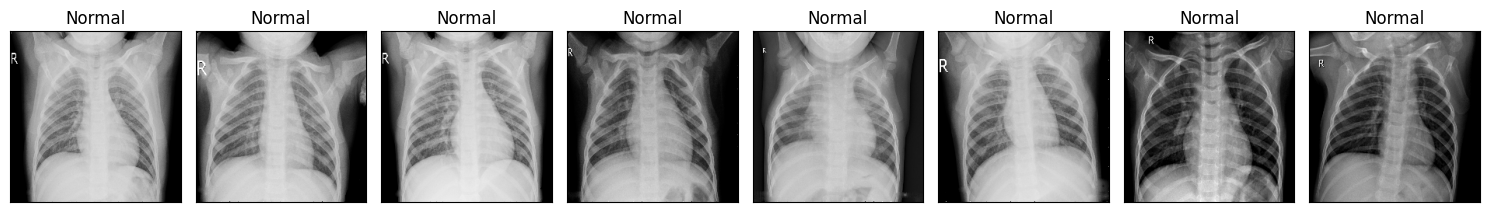

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 8, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
# Visualize the test data for comparison.
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_test_images[i])
    img = cv2.resize(img, (220, 220))
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()    

plt.show()